In [1]:
import json
import numpy as np
import os
import cv2
import scipy.io as sio
import copy
import random
import tensorflow as tf
from glob import glob
from tqdm import tqdm
import sys
import math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

/home2/user/anders/miniconda3/envs/anders_py38/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-02-28 21:57:03.710261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 21:57:03.798806: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
root_dir = "/home3/user/anders/objects/3D-head"
angle_300W_path = os.path.join(root_dir, "300W/annos/angles.npy")
angle_AFLW_path = os.path.join(root_dir, "AFLW/annos/angles.npy")
angle_CelebA_path = os.path.join(root_dir, "CelebA/annos/angles.npy")
angle_Driv_path = os.path.join(root_dir, "Driv/annos/angles.npy")
angle_FFHQ_path = os.path.join(root_dir, "FFHQ/annos/angles.npy")
angle_LFW_path = os.path.join(root_dir, "LFW/annos/angles.npy")
# angle_LS3D_W_path = os.path.join(root_dir, "LS3D-W/annos/angles.npy")
angle_openface_path = os.path.join(root_dir, "openface/annos/angles.npy")

In [8]:
angle_300W = np.load(angle_300W_path)
angle_AFLW = np.load(angle_AFLW_path)
angle_CelebA = np.load(angle_CelebA_path)
angle_Driv = np.load(angle_Driv_path)
angle_FFHQ = np.load(angle_FFHQ_path)
angle_LFW = np.load(angle_LFW_path)
angle_LS3D_W = np.load(angle_LS3D_W_path)
angle_openface = np.load(angle_openface_path)
angles = np.concatenate([angle_300W, angle_AFLW, angle_CelebA, angle_Driv, angle_FFHQ, angle_LFW, angle_openface], axis =0)


--------------------------------------------------------------------------------
8271.0


Text(0.5, 0, 'Pose angle')

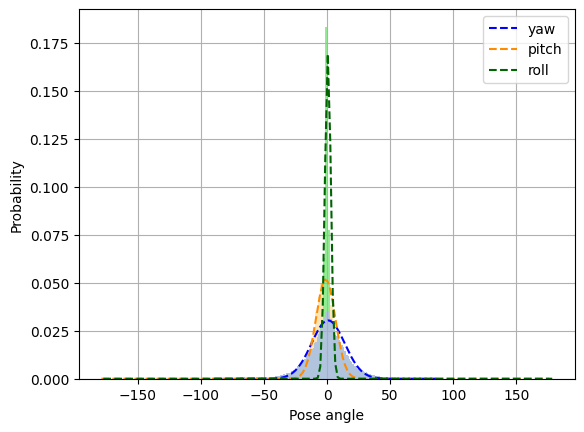

In [11]:

from scipy import optimize as op
def fitting_funs(bins, n):
    def f(x, mu, sigma):
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (x - mu))**2))
        return y
    mu, sigma = op.curve_fit(f, bins[1:], n)[0]
    fitted_y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    return fitted_y, mu, sigma


pitch, yaw, roll = angles[:, 0], angles[:, 1], angles[:, 2]
yaw_mask = np.asarray(yaw > 25).astype(np.float32)
values = np.sum(yaw_mask)
yaw_mask = np.asarray(yaw < -25).astype(np.float32)
values += np.sum(yaw_mask)
print('-'* 80)
print(values)



pitch = np.reshape(pitch, (-1))
pitch = np.where(pitch < 0., -(180 + pitch), (180 - pitch))
N,  = np.shape(pitch)

idxs = np.arange(N)
fig, ax = plt.subplots()

pitch_n, pitch_bins, _  = ax.hist(pitch, density=True, color="moccasin", bins=180)
fitting_pitch, _, _ = fitting_funs(pitch_bins, pitch_n)
roll_n, roll_bins, _  = ax.hist(roll, density=True, color="lightgreen", bins=180)
fitting_roll, _, _ = fitting_funs(roll_bins, roll_n)
yaw_n, yaw_bins, _  = ax.hist(yaw, density=True, color="lightsteelblue", bins=180)
fitting_yaw, _, _ = fitting_funs(yaw_bins, yaw_n)
ax.plot(yaw_bins, fitting_yaw, '--', color="blue", label = "yaw")
ax.plot(pitch_bins, fitting_pitch, '--', color="darkorange", label = "pitch")
ax.plot(roll_bins, fitting_roll, '--', color="darkgreen", label = "roll")
plt.grid()
plt.legend()
plt.ylabel('Probability')
plt.xlabel('Pose angle')

In [162]:
Rs = params[:, 1:10]
N, C = np.shape(Rs)
Rs = np.reshape(Rs, (N, 3, 3))
yaw = tf.math.asin(-Rs[..., 2, 0]) * (180 / np.pi)
pitch = tf.math.atan2(
            Rs[..., 2, 1] / tf.math.cos(yaw),
            Rs[..., 2, 2] / tf.math.cos(yaw)) * (180 / np.pi)
roll = tf.math.atan2(
    Rs[..., 1, 0] / tf.math.cos(yaw),
    Rs[..., 0, 0] / tf.math.cos(yaw)) * (180 / np.pi)
pitch = np.reshape(pitch, (-1))
pitch = np.where(pitch < 0., -(180 + pitch), (180 - pitch))
mask =  pitch < 100 
pitch = pitch[mask]
mask = pitch > -100
pitch = pitch[mask]

yaw = np.reshape(yaw, (-1))
roll = np.reshape(roll, (-1))
mask =  roll < 100 
roll = roll[mask]
mask = roll > -100
roll = roll[mask]

Text(0.5, 0, 'Pose angle')

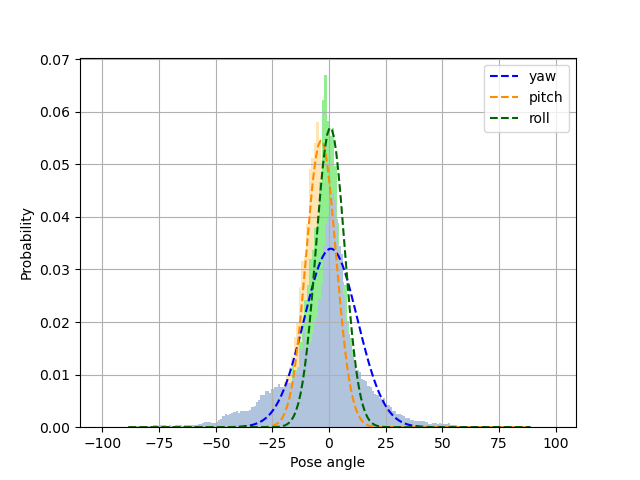

In [165]:

from scipy import optimize as op
def fitting_funs(bins, n):
    def f(x, mu, sigma):
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (x - mu))**2))
        return y
    mu, sigma = op.curve_fit(f, bins[1:], n)[0]
    fitted_y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
    return fitted_y, mu, sigma

idxs = np.arange(N)
fig, ax = plt.subplots()

pitch_n, pitch_bins, _  = ax.hist(pitch, density=True, color="moccasin", bins=180)
fitting_pitch, _, _ = fitting_funs(pitch_bins, pitch_n)

roll_n, roll_bins, _  = ax.hist(roll, density=True, color="lightgreen", bins=180)
fitting_roll, _, _ = fitting_funs(roll_bins, roll_n)
yaw_n, yaw_bins, _  = ax.hist(yaw, density=True, color="lightsteelblue", bins=180)
fitting_yaw, _, _ = fitting_funs(yaw_bins, yaw_n)
ax.plot(bins, fitting_yaw, '--', color="blue", label = "yaw")
ax.plot(bins, fitting_pitch, '--', color="darkorange", label = "pitch")
ax.plot(bins, fitting_roll, '--', color="darkgreen", label = "roll")
plt.grid()
plt.legend()
plt.ylabel('Probability')
plt.xlabel('Pose angle')

In [ ]:
fitting_yaw, mu, sigma = fitting_funs(yaw_bins, yaw_n)
P  = np.random.normal(loc=0.0, scale=1.0, size = N)
P = P + np.min(P)
P = P / P.sum()
sample_yaw = np.random.choice(yaw, 10000, p=P)

In [179]:
tmp_idxs = []
for sampled_yaw in sample_yaw:
    idx = np.where(yaw==sampled_yaw)[0][0]

    tmp_idxs.append(idx)
idxs = np.stack(tmp_idxs)

np.save("/aidata/anders/objects/3D-head/sample/annos/idxs.npy", idxs)
